# Voxel velocity distribution

When estimating a model and its uncertainty, one needs to know the underlying distribution of the modelled parameter. The naive solution is assuming that the distribution of galaxy velocities follows a Gaussian, such that the sum of squares in a voxel follows a $\chi^2$-distribution, which we will evaluate below.

In [1]:
import my_functions as mf
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit

In [2]:
dmo = mf.LoadSimulation('/net/hydra/data2/quinten/data/dmo_fiducial/SOAP-HBT/halo_properties_0077.hdf5')
dmo.selext_galaxies_mass_threshold([10**11, np.inf])
dmo.load_all(128)

Mass range: 11.0 - inf
Galaxies: 7009562


/data2/quinten/.venv4/lib64/python3.12/site-packages/swiftsimio/_array_functions.py:665: RuntimeWarning: Mixing arguments with and without cosmo_factors, continuing assuming provided cosmo_factor (a**0.0 at a=1.0) for all arguments.
  warnings.warn(
/data2/quinten/.venv4/lib64/python3.12/site-packages/swiftsimio/_array_functions.py:430: RuntimeWarning: Mixing arguments with and without cosmo_factors, continuing assuming provided cosmo_factor (a**0.0 at a=1.0) for all arguments.
  warnings.warn(
/data2/quinten/MRP/scripts/my_functions.py:102: RuntimeWarning: invalid value encountered in divide
  self.voxel_velocity = np.sqrt(voxel_velocity_sum_of_squares / voxel_count)
/data2/quinten/.venv4/lib64/python3.12/site-packages/swiftsimio/_array_functions.py:665: RuntimeWarning: Mixing arguments with and without cosmo_factors, continuing assuming provided cosmo_factor (a at a=1.0) for all arguments.
  warnings.warn(
/data2/quinten/MRP/scripts/my_functions.py:113: RuntimeWarning: invalid value 

The distribution of all RMS voxel velocities is shown below.

In [3]:
v = dmo.voxel_velocity[0][dmo.number_density > 0]
bin_edges = np.linspace(0.1, np.max(v), 100)


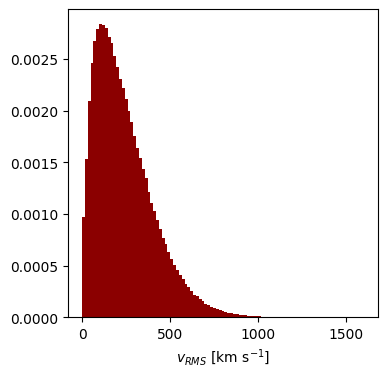

In [4]:
fig, ax = plt.subplots(1,1,figsize=[4,4])

xx = np.linspace(0, np.max(v), 100)

ax.hist(v, bins=bin_edges, color='darkred', density=True)

ax.set(
    xlabel='$v_{RMS}$ [km s$^{-1}$]',
)

plt.show()

The $\chi^2$-distribution is dependent on the number of free parameters, i.e. the number of galaxies in one voxel. To correctly fit a $\chi^2$-distribution to the data, we select only voxels with the same number of galaxies, e.g. $n_g=10$.

In [5]:
from scipy.stats import chi2

In [6]:
# Convert RMS velocity to sum of squares velocity, as this is the what a chi-squared distribution describes
def chi2_pdf(v_rms, dof, loc, scale, height):
    return chi2.pdf(dof*v_rms**2, dof, loc, scale) * height

In [7]:
def chi2_pdf_fixed_dof(dof):
    return lambda v_rms, loc, scale, height, dof=dof: chi2_pdf(v_rms, dof, loc, scale, height)

In [8]:
def binned_v_probability(v):
    bin_edges = np.linspace(0, np.max(v), 101)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    xspace = bin_edges[1] - bin_edges[0]
    counts = np.histogram(v, bin_edges)[0]
    pmf_data = counts / np.sum(counts) / xspace
    return bin_centers, pmf_data

In [9]:
n_g = 10
v = dmo.voxel_velocity[0][dmo.number_density == n_g]
bin_centers, pmf_data = binned_v_probability(v)

In [10]:
fit, _ = curve_fit(chi2_pdf_fixed_dof(n_g), bin_centers, pmf_data, p0=[-100000, 100000, 30000])

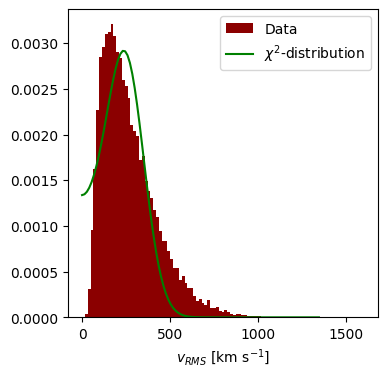

In [11]:
fig, ax = plt.subplots(1,1,figsize=[4,4])

xx = np.linspace(0, np.max(v), 100)

ax.hist(v, bins=bin_edges, label='Data', color='darkred', density=True)
ax.plot(xx, chi2_pdf(xx, n_g, *fit), label=r'$\chi^2$-distribution', color='green')
ax.legend()

ax.set(
    xlabel='$v_{RMS}$ [km s$^{-1}$]',
)

plt.show()

This fit is obviously not great. One reason this may be the case is that a $\chi^2$-distribution describes independent variables. The velocities are not independent, which causes a problem. Another possibility is fitting a $\chi^2$-distribution without fixing the degrees of freedom of the model, which is done below for multiple galaxy number densities.

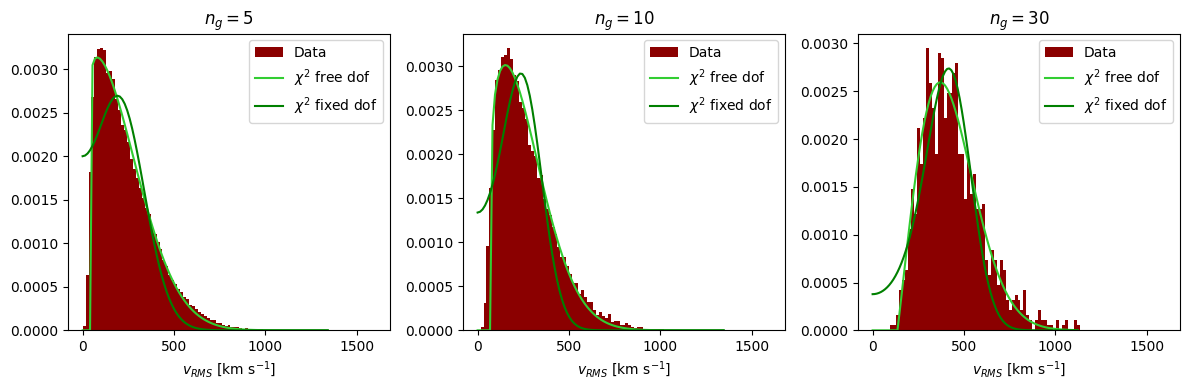

In [12]:
fig, ax = plt.subplots(1,3,figsize=[12,4])

for axis, n_g in zip(ax, [5, 10, 30]):
    v = dmo.voxel_velocity[0][dmo.number_density == n_g]
    bin_centers, pmf_data = binned_v_probability(v)
    
    fit_free_dof, _ = curve_fit(chi2_pdf, bin_centers, pmf_data, p0=[n_g-1, 0, 100000, 600])
    fit_fixed_dof, _ = curve_fit(chi2_pdf_fixed_dof(n_g), bin_centers, pmf_data, p0=[0, 100000, 1000])

    xx = np.linspace(0, np.max(v), 100)

    axis.hist(v, bins=bin_edges, label='Data', color='darkred', density=True)
    axis.plot(xx, chi2_pdf(xx, *fit_free_dof), label=r'$\chi^2$ free dof', color='limegreen')
    axis.plot(xx, chi2_pdf(xx, n_g, *fit_fixed_dof), label=r'$\chi^2$ fixed dof', color='green')
    axis.legend()

    axis.set(
        xlabel='$v_{RMS}$ [km s$^{-1}$]',
        title=f'$n_g=${n_g}'
    )

fig.tight_layout()
plt.show()

Keeping the degrees of freedom as a free parameter greatly increases the fits. However, there is not a lot of physical explanation of why this should be allowed. Also, since the fits are still not perfect, we explore two other options: the Maxwell-Boltzman distribution and the skew normal distribution.

In [13]:
from scipy.stats import skewnorm

In [14]:
# The maxwell Boltzman distribution, scaled with 'width' and translated along the x-axis with 'loc'
def maxwell_pdf(x, a, width, loc):
    return np.sqrt(2/np.pi) * ((x-loc)*width)**2/a**3 * np.exp(-((x-loc)*width)**2/2/a**2)

In [15]:
def skewnorm_pdf(x, a, b, c):
    return skewnorm.pdf(x, a, b, c)

def skewnorm_cdf(x, a, b, c):
    return skewnorm.cdf(x, a, b, c)

In [16]:
v = dmo.voxel_velocity[0][dmo.number_density > 0]
bin_centers, pdf_data = binned_v_probability(v)

In [17]:
fit_mb, _ = curve_fit(maxwell_pdf, bin_centers, pdf_data, p0=[100, 1, 0])
fit_sn, _ = curve_fit(skewnorm_pdf, bin_centers, pdf_data)

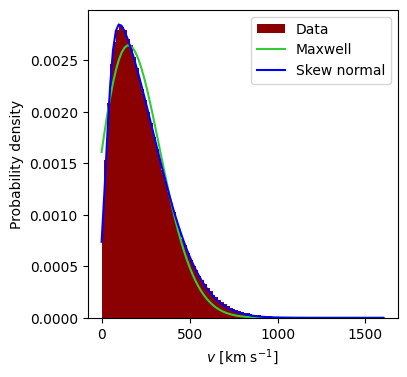

In [18]:
fig, ax = plt.subplots(1,1,figsize=[4,4])

xx = np.linspace(0, np.max(v), 100)

ax.hist(v, bins=bin_edges, label='Data', color='darkred', density=True)
ax.plot(xx, maxwell_pdf(xx, *fit_mb), label='Maxwell', color='limegreen')
ax.plot(xx, skewnorm_pdf(xx, *fit_sn), label='Skew normal', color='blue')
ax.legend()

ax.set(
    xlabel='$v$ [km s$^{-1}$]',
    ylabel='Probability density',
)

plt.show()

The skew normal distribution is a very good fit to the whole population of RMS voxel velocities. It is useful to test whether it describes voxel velocities with fixed number densities as well.

In [20]:
def fit_skew_norm_pdf(v, n_bins, p0=None):
    bin_edges = np.linspace(0, 1.1*np.max(v), n_bins+1)
    bin_centers, pmf_data = binned_v_probability(v)
    fit, _ = curve_fit(skewnorm_pdf, bin_centers, pmf_data, p0=p0)
    return bin_edges, fit

In [21]:
def plot_skew_norm(ax, bin_edges, fit):
    ax.hist(v, bins=bin_edges, label='Data', color='darkred', density=True)

    xx = np.linspace(0, 1.1*np.max(v), 100)
    ax.plot(xx, skewnorm_pdf(xx, *fit), label='Skew normal', color='blue')

/var/tmp/zegveld/ipykernel_214964/371575860.py:4: OptimizeWarning: Covariance of the parameters could not be estimated
  fit, _ = curve_fit(skewnorm_pdf, bin_centers, pmf_data, p0=p0)
/var/tmp/zegveld/ipykernel_214964/239764902.py:8: OptimizeWarning: Covariance of the parameters could not be estimated
  fit, _ = curve_fit(skewnorm_pdf, bin_centers, pdf_data, p0=p0)


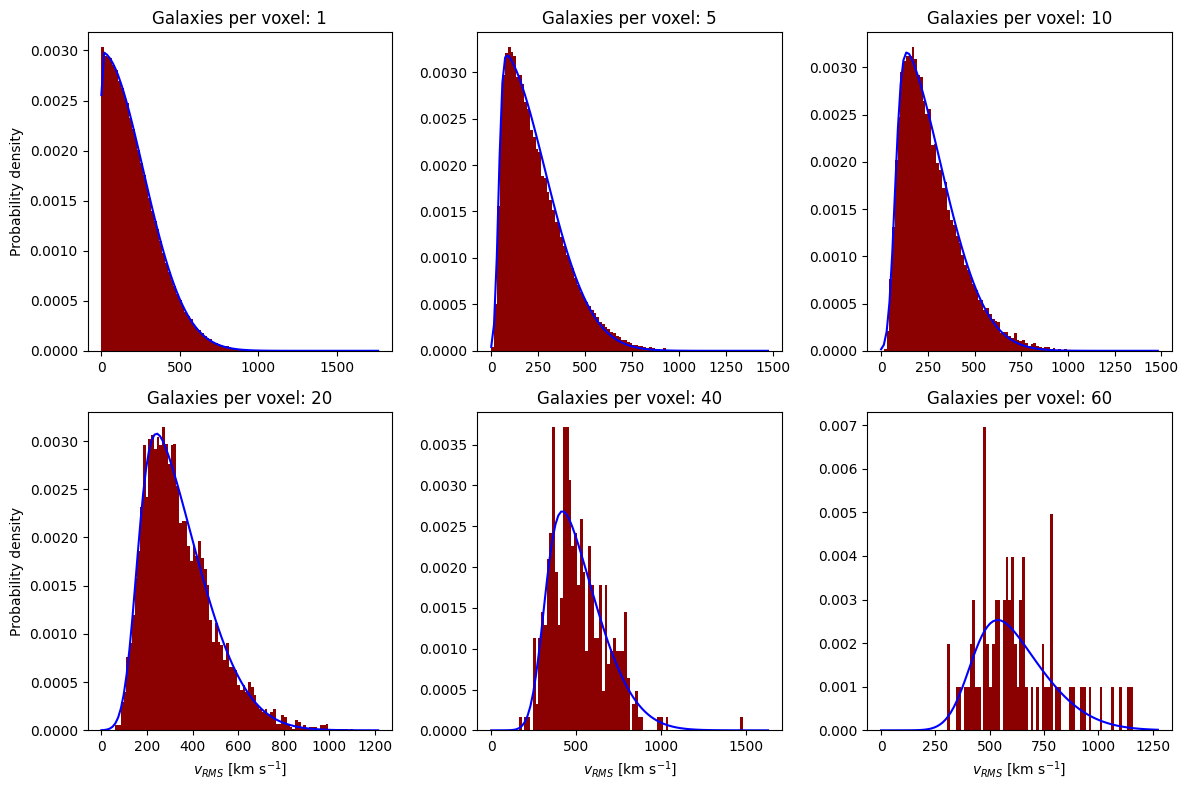

In [22]:
fig, ax = plt.subplots(2, 3,figsize=[12, 8])

_, p0 = fit_skew_norm_pdf(dmo.voxel_velocity[0][dmo.number_density > 0], 100)
for n_g, axis in zip([1, 5, 10, 20, 40, 60], ax.flatten()):
    v = dmo.voxel_velocity[0][dmo.number_density == n_g]
    bin_edges, fit = fit_skew_norm_pdf(v, 100, p0)
    bin_centers, pdf_data = binned_v_probability(v)
    fit, _ = curve_fit(skewnorm_pdf, bin_centers, pdf_data, p0=p0)
    plot_skew_norm(axis, bin_edges, fit)
    axis.set_title(f'Galaxies per voxel: {n_g}')

for axis in ax[:, 0]:
    axis.set_ylabel('Probability density')
for axis in ax[1, :]:
    axis.set_xlabel('$v_{RMS}$ [km s$^{-1}$]')


fig.tight_layout()
plt.show()

The skew normal distribution describes the RMS voxel velocities well. From now on, we will use this distribution for the voxel velocities.

The skew normal distribution, $$f(x;\xi,\omega,\alpha)=\frac{2}{\omega\sqrt{2\pi}}\exp\!\left(-\frac{(x-\xi)^2}{2\omega^2}\right)\int_{-\infty}^{\alpha (x-\xi)/\omega}\frac{1}{\sqrt{2\pi}} e^{-t^2/2}\,dt$$is described by $\alpha$ that influences the skewness, $\xi$ that affects the location and $\omega$ that influences the width. To describe all data at once, we need to model the parameters $\alpha$, $\xi$ and $\omega$ as a function of number density to obtain a complete estimate of the voxel velocities.

In [23]:
_, fit = fit_skew_norm_pdf(dmo.voxel_velocity[0][dmo.number_density > 0], 100)
fits = []
n_gs = np.arange(2, 61) # Note that we start at n_g=2, as the voxel velocities of n_g=1 behave as a half Gaussian, leading to alpha=inf
for n_g in n_gs:
    v = dmo.voxel_velocity[0][dmo.number_density == n_g]
    bin_edges, fit = fit_skew_norm_pdf(v, 100, p0=fit)
    fits.append(fit)
alpha, xi, omega = np.array(fits).T

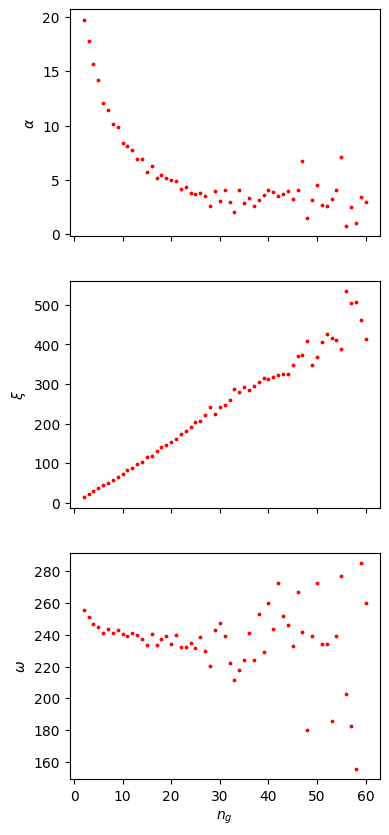

In [24]:
fig, ax = plt.subplots(3, 1, figsize=[4, 10], sharex=True)

ax[0].scatter(n_gs, alpha, s=3, c='r')
ax[1].scatter(n_gs, xi, s=3, c='r')
ax[2].scatter(n_gs, omega, s=3, c='r')

ax[2].set(
    xlabel='$n_g$',
)

for axis, ylabel in zip(ax, [r'$\alpha$', r'$\xi$', r'$\omega$']):
    axis.set_ylabel(ylabel)

plt.show()

From this plot it is very clear that we can constrain $\xi=a\cdot x$. $\omega$ does not have a very prominent functional form, but behaves relatively constant, so we simply choose $\omega=c$. This gives the following fits.

In [25]:
slope, _ = curve_fit(lambda x, a: a*x, n_gs, xi)

_, p0 = fit_skew_norm_pdf(dmo.voxel_velocity[0][dmo.number_density > 0], 100) # Initial p0
fit = p0[:-2]
fits = []
for n_g in n_gs:
    v = dmo.voxel_velocity[0][dmo.number_density == n_g]
    bin_edges = np.linspace(0, np.max(v), 100)
    bin_centers, pdf_data = binned_v_probability(v)
    fit, _ = curve_fit(lambda x, a, n_g=n_g: skewnorm_pdf(x, a, n_g*slope, np.mean(omega)), bin_centers, pdf_data, p0=fit[0])
    fits.append(fit)
alpha = np.array(fits).T[0]

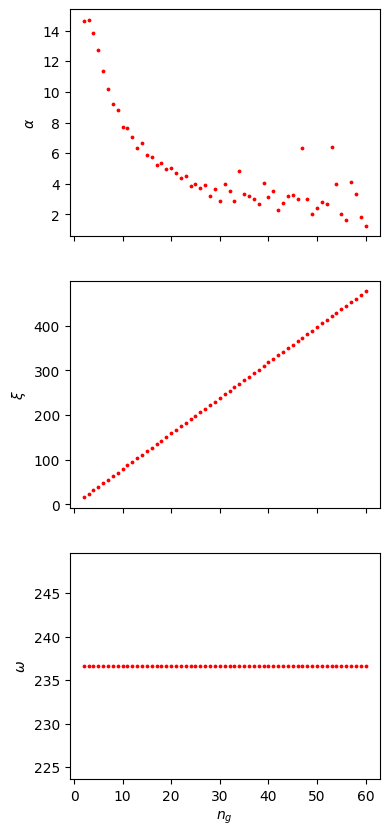

In [26]:
fig, ax = plt.subplots(3, 1, figsize=[4, 10], sharex=True)

ax[0].scatter(n_gs, alpha, s=3, c='r')
ax[1].scatter(n_gs, slope*n_gs, s=3, c='r')
ax[2].scatter(n_gs, [np.mean(omega)]*len(n_gs), s=3, c='r')

ax[0].set(
    ylabel=r'$\alpha$',
)
ax[1].set(
    ylabel=r'$\xi$',
)
ax[2].set(
    xlabel='$n_g$',
    ylabel=r'$\omega$',
)

plt.show()

The final parameter that needs to be constrained is $\alpha$. We choose the form $\alpha=a\cdot e^{-bx}+c$.

In [27]:
exponential = lambda x, a, b, c: a*np.exp(-b*x)+c
fit, _ = curve_fit(exponential, n_gs, alpha, p0=[10, .1, 3])

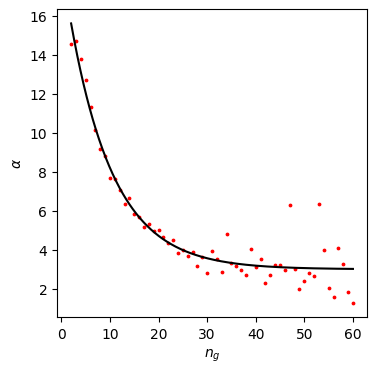

In [28]:
fig, ax = plt.subplots(1,1,figsize=[4,4])

xx = np.linspace(np.min(n_gs), np.max(n_gs), 1000)

ax.scatter(n_gs, alpha, s=3, c='r')
ax.plot(xx, exponential(xx, *fit), 'black')
ax.set(
    xlabel='$n_g$',
    ylabel=r'$\alpha$',
)
plt.show()

The exponential function describes $\alpha$ well. To obtain a general description, we perform a joint fit of the parameters 

In [29]:
def joint_fit(x_array, alpha1, alpha2, alpha3, beta_slope, gamma):
    x_array = x_array.reshape(len(x_array)//100, 100)
    n_gs = np.arange(2, len(x_array)+2)
    pdf_model = []
    for x, n_g in zip(x_array, n_gs):
        pdf_model.append(skewnorm_pdf(x, exponential(n_g, alpha1, alpha2, alpha3), beta_slope*n_g, gamma))
    return np.array(pdf_model).flatten()

In [30]:
# Note that some form of errors should probably be added to downweight the uncertain high number density voxels
n_g_max = 60
n_gs = np.arange(2, n_g_max+1)
bin_centers_array, pmf_array = np.transpose([binned_v_probability(dmo.voxel_velocity[0][dmo.number_density == n_g]) for n_g in n_gs], (1,0,2))
bin_centers_array = bin_centers_array.flatten()
pmf_array = pmf_array.flatten()
# sigma = np.array([[n_g**2+200]*100 for n_g in n_gs]).flatten()
# (alpha1, alpha2, alpha3, beta_slope, gamma), cov = curve_fit(joint_fit, bin_centers_array, pmf_array, sigma=sigma, p0=[16, 0.1, 3, 8, 237])
(alpha1, alpha2, alpha3, beta_slope, gamma), cov = curve_fit(joint_fit, bin_centers_array, pmf_array, p0=[16, 0.1, 3, 8, 237])
error = np.diag(cov)**.5
print(alpha1, alpha2, alpha3, beta_slope, gamma, error)

15.55210063661604 0.09869258002868972 2.954201990797198 7.770255779963261 241.07644433238033 [2.79118531 0.0128664  0.14762318 0.03103635 1.77840628]


In [31]:
_, fit = fit_skew_norm_pdf(dmo.voxel_velocity[0][dmo.number_density > 0], 100)
fits = []
for n_g in n_gs:
    v = dmo.voxel_velocity[0][dmo.number_density == n_g]
    bin_edges, fit = fit_skew_norm_pdf(v, 100, p0=fit)
    fits.append(fit)
alphas, betas, gammas = np.array(fits).T

In [32]:
betas_slope = curve_fit(lambda x, a: a*x, n_gs, betas)[0][0]
gammas_mean = np.mean(gammas)
alphas_fit, _ = curve_fit(exponential, n_gs, alphas, p0=[10, .1, 3])

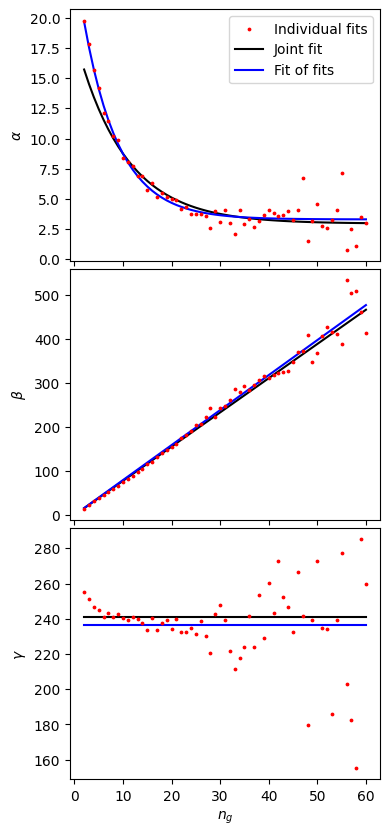

In [33]:
fig, ax = plt.subplots(3,1,figsize=[4,10], sharex=True)

ax[0].scatter(n_gs, alphas, s=3, c='r', label='Individual fits', zorder=10)
ax[1].scatter(n_gs, betas, s=3, c='r', label='Individual fits', zorder=10)
ax[2].scatter(n_gs, gammas, s=3, c='r', label='Individual fits', zorder=10)

ax[0].plot(n_gs, exponential(n_gs, alpha1, alpha2, alpha3), c='black', label='Joint fit')
ax[1].plot(n_gs, n_gs*beta_slope, c='black', label='Joint fit')
ax[2].plot(n_gs, [gamma]*len(n_gs), c='black', label='Joint fit')

ax[0].plot(n_gs, exponential(n_gs, *alphas_fit), c='b', label='Fit of fits')
ax[1].plot(n_gs, n_gs*betas_slope, c='b', label='Fit of fits')
ax[2].plot(n_gs, [gammas_mean]*len(n_gs), c='b', label='Fit of fits')

ax[0].set(
    ylabel=r'$\alpha$',
)
ax[1].set(
    ylabel=r'$\beta$',
)
ax[2].set(
    xlabel='$n_g$',
    ylabel=r'$\gamma$',
)

ax[0].legend()
fig.subplots_adjust(hspace=.03)
plt.show()

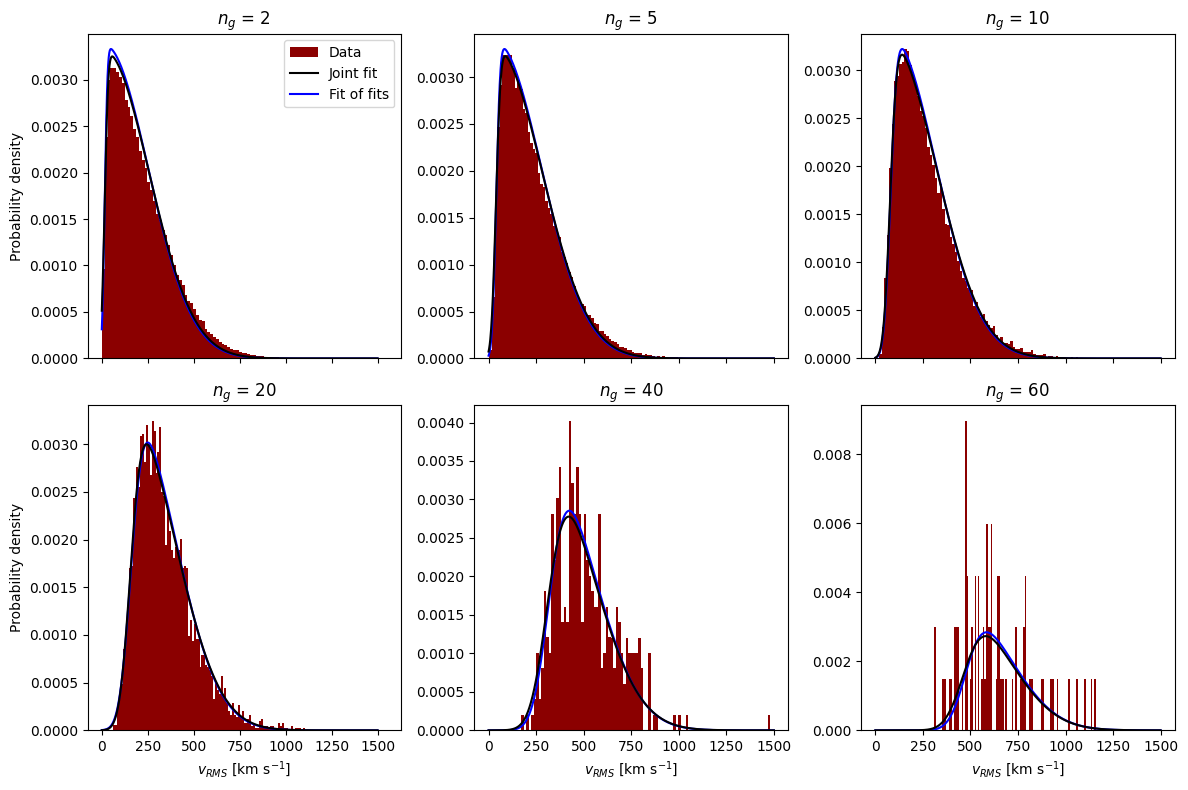

In [34]:
fig, ax = plt.subplots(2, 3,figsize=[12, 8], sharex='col')

_, p0 = fit_skew_norm_pdf(dmo.voxel_velocity[0][dmo.number_density > 0], 100)
for n_g, axis in zip([2, 5, 10, 20, 40, 60], ax.flatten()):
    axis.hist(dmo.voxel_velocity[0][dmo.number_density == n_g], bins=100, density=True, color='darkred', label='Data')
    xx = np.linspace(0, 1500, 1000)
    axis.plot(xx, skewnorm_pdf(xx, exponential(n_g, alpha1, alpha2, alpha3), beta_slope*n_g, gamma), c='black', zorder=10, label='Joint fit')
    axis.plot(xx, skewnorm_pdf(xx, exponential(n_g, *alphas_fit), betas_slope*n_g, gammas_mean), c='b', label='Fit of fits')
    axis.set_title(f'$n_g$ = {n_g}')

for axis in ax[:, 0]:
    axis.set_ylabel('Probability density')
for axis in ax[1, :]:
    axis.set_xlabel('$v_{RMS}$ [km s$^{-1}$]')
ax[0,0].legend()

fig.tight_layout()
plt.show()

By plotting the CDFs following from both fitting methods, we find that, as expected, the joint fit generally produces better results.

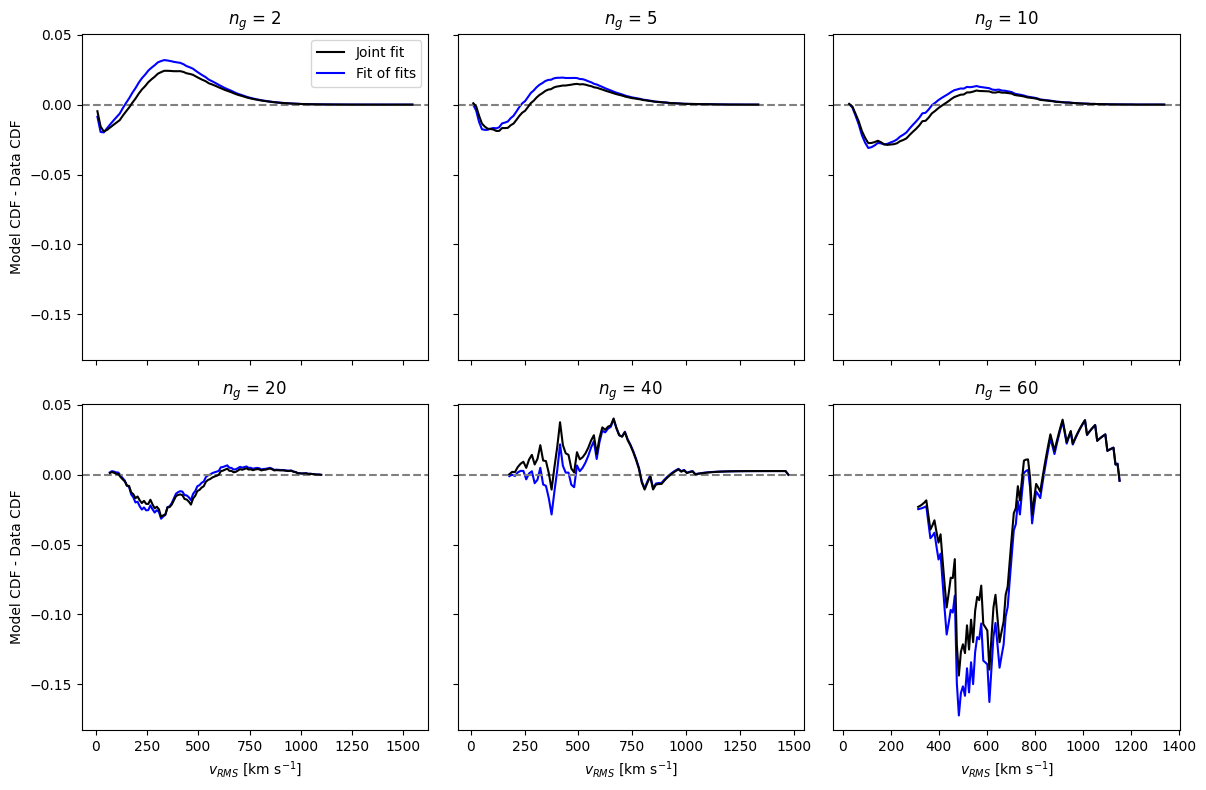

In [35]:
fig, ax = plt.subplots(2, 3,figsize=[12, 8], sharex='col', sharey=True)

_, p0 = fit_skew_norm_pdf(dmo.voxel_velocity[0][dmo.number_density > 0], 100)
for n_g, axis in zip([2, 5, 10, 20, 40, 60], ax.flatten()):
    cmf, bin_edges = np.histogram(dmo.voxel_velocity[0][dmo.number_density == n_g], bins=100)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    for i in range(99):
        cmf[i+1] += cmf[i]
    cmf = cmf/cmf[-1]
    axis.plot(bin_centers, skewnorm_cdf(bin_centers, exponential(n_g, alpha1, alpha2, alpha3), beta_slope*n_g, gamma)-cmf, c='black', zorder=10, label='Joint fit')
    axis.plot(bin_centers, skewnorm_cdf(bin_centers, exponential(n_g, *alphas_fit), betas_slope*n_g, gammas_mean)-cmf, c='b', label='Fit of fits')
    axis.axhline(0, linestyle='--', color='gray')
    axis.set_title(f'$n_g$ = {n_g}')

for axis in ax[:, 0]:
    axis.set_ylabel('Model CDF - Data CDF')
for axis in ax[1, :]:
    axis.set_xlabel('$v_{RMS}$ [km s$^{-1}$]')
ax[0,0].legend()

fig.tight_layout()
plt.show()

For the high number density plots, it is evident that the PDF may not be a very well suited model. To obtain better fitting parameters, we switch to directly fitting the skew normal CDF to the CDF of the data. The enhanced performence of the CDF is demonstrated below.

In [36]:
def fit_skew_norm_cdf(v, n_bins, p0=None):
    bin_edges = np.linspace(0, 1.1*np.max(v), n_bins+1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    cdf_data = np.histogram(v, bin_edges)[0].astype(np.float64)
    for i in range(n_bins-1):
        cdf_data[i+1] += cdf_data[i]
    cdf_data /= cdf_data[-1]
    cdf_fit, _ = curve_fit(skewnorm_cdf, bin_centers, cdf_data, p0=p0)
    return bin_centers, cdf_fit, cdf_data

/var/tmp/zegveld/ipykernel_214964/3409811500.py:8: OptimizeWarning: Covariance of the parameters could not be estimated
  cdf_fit, _ = curve_fit(skewnorm_cdf, bin_centers, cdf_data, p0=p0)


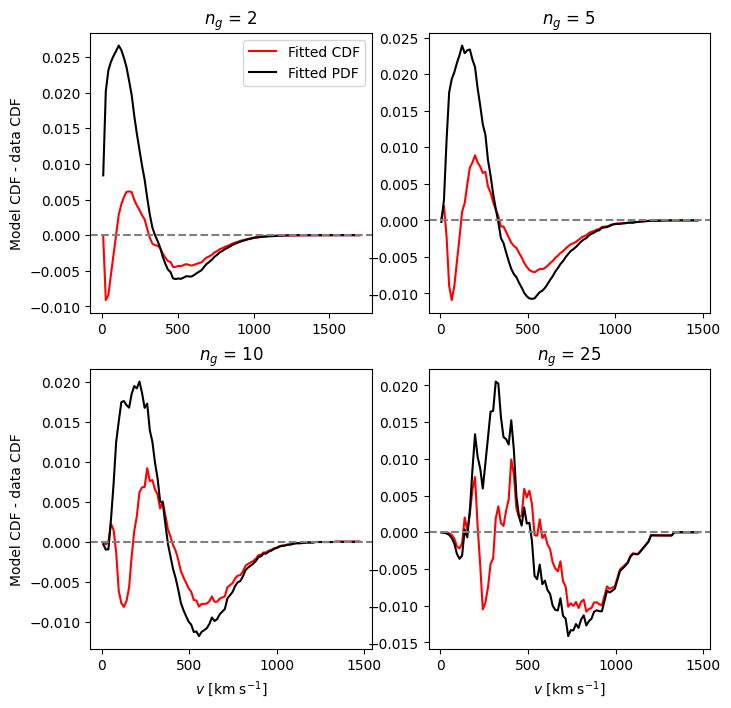

In [37]:
fig, ax = plt.subplots(2,2, figsize=[8,8])

n_bins=100
for axis, n_g in zip(ax.flatten(), [2, 5, 10, 25]):
    v = dmo.voxel_velocity[0][dmo.number_density == n_g]
    bin_centers, cdf_fit, cdf_data = fit_skew_norm_cdf(v, n_bins, p0=[10, 200, 200])
    _, pdf_fit = fit_skew_norm_pdf(v, n_bins, p0=[10, 200, 200])
    axis.plot(bin_centers, cdf_data - skewnorm_cdf(bin_centers, *cdf_fit), label='Fitted CDF', c='r')
    axis.plot(bin_centers, cdf_data - skewnorm_cdf(bin_centers, *pdf_fit), label='Fitted PDF', c='black')
    axis.axhline(0, c='gray', linestyle='--')
    axis.set_title(f'$n_g$ = {n_g}')

for i in range(2):
    ax[i, 0].set_ylabel('Model CDF - data CDF')
    ax[1, i].set_xlabel('$v$ [km s$^{-1}$]')

ax[0,0].legend()
plt.show()

In [38]:
def pdf_to_cdf(pdf):
    cdf = pdf.copy()
    for i in range(len(cdf)-1):
        cdf[i+1] += cdf[i]
    return cdf / cdf[-1]

To do: create a working joint fit for the CDF case & somehow incorporate errors in the joint fit